In [3]:
# CHUNK 0: Dataset Initialization and Verification

import os

DATA_DIR = "/content/cardd"

# 1. Verify if Dataset Exists
# We check if the data directory is already populated to prevent redundant downloads.
print(f"Verifying dataset integrity at: {DATA_DIR}...")

if os.path.exists(DATA_DIR) and os.listdir(DATA_DIR):
    print("Dataset directory found. Verification successful.")
    print("Contents:")
    for name in os.listdir(DATA_DIR):
        print(f" - {name}")
else:
    print("Dataset not found. Initiating download sequence...")

    # 2. Credential Verification
    # Ensure Kaggle API token is present before attempting download.
    if not os.path.exists("kaggle.json"):
        raise FileNotFoundError("Error: 'kaggle.json' not found. Please upload the API token to the Files panel.")

    # 3. Configure Kaggle Environment
    print("Configuring API credentials...")
    os.system("mkdir -p ~/.kaggle")
    os.system("cp kaggle.json ~/.kaggle/")
    os.system("chmod 600 ~/.kaggle/kaggle.json")

    # 4. Download and Extract Data
    print("Downloading dataset from Kaggle (Source: issamjebnouni/cardd)...")
    os.makedirs(DATA_DIR, exist_ok=True)
    os.system(f"kaggle datasets download -d issamjebnouni/cardd -p {DATA_DIR} --unzip")

    print("Download complete. Verifying contents:")
    for name in os.listdir(DATA_DIR):
        print(f" - {name}")

print("CHUNK 0 COMPLETE: Data is ready.")

Verifying dataset integrity at: /content/cardd...
Dataset not found. Initiating download sequence...
Configuring API credentials...
Download complete. Verifying contents:
 - val
 - test
 - test.json
 - train.json
 - val.json
 - image_info.xlsx
 - train
CHUNK 0 COMPLETE: Data is ready.


In [4]:
# Chunk 1: Dataset Inspection and JSON Discovery

import os
import json

# Define the primary dataset directory
DATA_DIR = "/content/cardd"

# 1. Verify Dataset Directory
# I am checking if the dataset folder exists to ensure previous download steps succeeded.
print(f"Checking availability of {DATA_DIR}...")
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Directory {DATA_DIR} not found. Ensure the data download step was completed.")

print("Listing top-level directory contents:")
for name in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, name)
    if os.path.isdir(path):
        print(f" [DIR]  {name}")
    else:
        print(f" [FILE] {name}")

# 2. JSON File Discovery
# I am using os.walk to recursively search for all JSON files, as Kaggle datasets
# often nest annotations in subdirectories.
json_paths = []
for root, dirs, files in os.walk(DATA_DIR):
    for fname in files:
        if fname.lower().endswith(".json"):
            json_paths.append(os.path.join(root, fname))

print(f"Total JSON files discovered: {len(json_paths)}")

if not json_paths:
    print("Warning: No JSON files found. Manual inspection of the dataset structure may be required.")
else:
    for p in json_paths:
        print(f" - {p}")

# 3. Schema Validation
# I am loading the first available JSON file to verify it follows the expected COCO format.
# This checks for required keys: 'images', 'annotations', and 'categories'.
if json_paths:
    sample_json = json_paths[0]
    print(f"Validating schema of: {sample_json}")
    try:
        with open(sample_json, "r") as f:
            data = json.load(f)

        if isinstance(data, dict):
            keys = list(data.keys())
            print(f"Successfully loaded. Root keys detected: {keys}")

            # Verification of COCO format
            if 'images' in keys and 'annotations' in keys:
                print("Validation Successful: File appears to be a valid COCO annotation format.")
            else:
                print("Validation Warning: File structure differs from standard COCO format.")
        else:
            print(f"Invalid format. Expected dictionary, got: {type(data)}")

    except Exception as e:
        print(f"Error reading JSON file: {e}")

print("Chunk 1 Complete.")

Checking availability of /content/cardd...
Listing top-level directory contents:
 [DIR]  val
 [DIR]  test
 [FILE] test.json
 [FILE] train.json
 [FILE] val.json
 [FILE] image_info.xlsx
 [DIR]  train
Total JSON files discovered: 3
 - /content/cardd/test.json
 - /content/cardd/train.json
 - /content/cardd/val.json
Validating schema of: /content/cardd/test.json
Successfully loaded. Root keys detected: ['licenses', 'info', 'categories', 'images', 'annotations']
Validation Successful: File appears to be a valid COCO annotation format.
Chunk 1 Complete.


In [5]:
# CHUNK 1: Spark Setup (Modified)
!pip install findspark
!pip install pyspark

import os
import findspark
from pyspark.sql import SparkSession

if 'spark' not in globals():
    print("Spark session not found, creating a new one...")
    findspark.init()
    spark = (
        SparkSession.builder
        .appName("CarInsuranceClaimEstimator")
        .config("spark.driver.memory", "4g")
        .config("spark.executor.memory", "4g")
        # Removed the HDFS configuration, as we intend to save locally.
        #.config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000")
        .getOrCreate()
    )
    print("Spark session created.")
else:
    print("Spark session already exists.")

Spark session not found, creating a new one...
Spark session created.


In [6]:
# CHUNK 2: COCO Ground Truth + EfficientNet Features


import os
import json
import numpy as np
from collections import defaultdict
from tqdm import tqdm

# Deep Learning imports
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing import image

# Spark imports
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

# Basic checks
DATA_DIR = "/content/cardd"
assert os.path.exists(DATA_DIR), "Run CHUNK 1 first so /content/cardd is created."
assert 'spark' in globals(), "Spark session not found. Run CHUNK 1 before CHUNK 2."

print("CHUNK 2: Starting COCO-based feature extraction...")

# Step 1: Read COCO JSONs and build filename -> labels
json_files = []
for root, dirs, files in os.walk(DATA_DIR):
    for fname in files:
        if fname.lower().endswith(".json"):
            json_files.append(os.path.join(root, fname))

if not json_files:
    raise FileNotFoundError("No annotation JSON files found under /content/cardd.")

print(f"Found {len(json_files)} JSON files. Parsing annotations...")

filename_to_labels = defaultdict(list)

for ann_path in json_files:
    try:
        with open(ann_path, "r") as f:
            coco = json.load(f)

        if not isinstance(coco, dict):
            continue
        if not all(k in coco for k in ("images", "annotations", "categories")):
            continue

        cat_map = {c["id"]: c["name"] for c in coco["categories"]}
        img_map = {img["id"]: img["file_name"] for img in coco["images"]}

        for ann in coco["annotations"]:
            img_id = ann.get("image_id")
            cat_id = ann.get("category_id")
            fname = img_map.get(img_id)
            cname = cat_map.get(cat_id)

            if fname and cname:
                clean_name = os.path.basename(fname)
                clean_cat = cname.lower().strip().replace(" ", "_").replace("-", "_")
                filename_to_labels[clean_name].append(clean_cat)
    except Exception as e:
        print(f"[WARN] Skipping {ann_path}: {e}")

print(f"Images with at least one ground-truth label: {len(filename_to_labels)}")

# Step 2: Collect all image paths
img_paths = []
for root, dirs, files in os.walk(DATA_DIR):
    for name in files:
        if name.lower().endswith((".jpg", ".jpeg", ".png")):
            img_paths.append(os.path.join(root, name))

print(f"Total image files found: {len(img_paths)}")

#  Step 3: EfficientNet feature extraction
print("Loading EfficientNetB0...")
cnn_model = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg")

def extract_features(img_path):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feat = cnn_model.predict(x, verbose=0)[0]
        return feat.astype("float32")
    except Exception as e:
        print(f"[WARN] Failed on {img_path}: {e}")
        return None

def choose_main_label(labels):
    # pick the most frequent label for that filename
    return max(set(labels), key=labels.count)

rng = np.random.default_rng(123)
data_rows = []

print("Processing images and building dataset...")

for i, path in enumerate(tqdm(img_paths)):
    fname = os.path.basename(path)
    labels = filename_to_labels.get(fname)
    if not labels:
        # image has no annotation -> skip
        continue

    damage_type = choose_main_label(labels)
    feats = extract_features(path)
    if feats is None:
        continue

    # Synthetic insurance-style metadata
    driver_age = int(rng.integers(18, 75))
    car_year   = int(rng.integers(2005, 2024))
    mileage    = int(rng.integers(5_000, 220_000))

    # Bias severity based on real damage type
    if damage_type in ("glass_shatter", "lamp_broken", "tire_flat"):
        base_sev = 3.5
    elif damage_type in ("crack", "dent"):
        base_sev = 2.2
    else:  # scratch or others
        base_sev = 1.4

    severity_score = float(np.clip(base_sev + rng.normal(0, 0.5), 0.5, 5.0))

    data_rows.append((
        f"claim_{i}",
        path,                 # keep image path for debugging / demo
        feats.tolist(),
        driver_age,
        car_year,
        mileage,
        damage_type,
        severity_score
    ))

print(f"Total rows with features + labels: {len(data_rows)}")

#  Step 4: Create Spark DataFrame
schema = StructType([
    StructField("claim_id",       StringType(), True),
    StructField("image_path",     StringType(), True),
    StructField("features",       ArrayType(FloatType()), True),
    StructField("driver_age",     IntegerType(), True),
    StructField("car_year",       IntegerType(), True),
    StructField("mileage",        IntegerType(), True),
    StructField("damage_type",    StringType(), True),
    StructField("severity_score", FloatType(), True),
])

df_spark = spark.createDataFrame(data_rows, schema)

# Add vector column for Spark ML
to_vector = udf(lambda xs: Vectors.dense(xs), VectorUDT())
df_spark = df_spark.withColumn("features_vec", to_vector("features"))

#  Step 5: Save locally (no HDFS)
local_output = "/content/cardd/claims_with_image_features_parquet"
print(f"Saving dataset locally to: {local_output}")
df_spark.write.mode("overwrite").parquet(local_output)

print("CHUNK 2 COMPLETE: Dataset saved to local parquet.")


CHUNK 2: Starting COCO-based feature extraction...
Found 3 JSON files. Parsing annotations...
Images with at least one ground-truth label: 4000
Total image files found: 4000
Loading EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Processing images and building dataset...


100%|██████████| 4000/4000 [06:10<00:00, 10.79it/s]


Total rows with features + labels: 4000
Saving dataset locally to: /content/cardd/claims_with_image_features_parquet
CHUNK 2 COMPLETE: Dataset saved to local parquet.


In [7]:
# SAVE VIA LOCAL FILESYSTEM (NO HDFS)

# Make sure df_spark still exists
print("df_spark rows:", df_spark.count())

local_output = "file:///content/cardd/claims_with_image_features_parquet"
print(f"Saving dataset to local filesystem at: {local_output}")

df_spark.write.mode("overwrite").parquet(local_output)

print(" Save successful to local path.")

df_spark rows: 4000
Saving dataset to local filesystem at: file:///content/cardd/claims_with_image_features_parquet
 Save successful to local path.


In [8]:

# CHUNK 3: Create repair_cost label + Train GBT Model


from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

# 1. Load the dataset from local parquet (no HDFS)
input_path = "file:///content/cardd/claims_with_image_features_parquet"
print(f"Loading dataset from: {input_path}")

df = spark.read.parquet(input_path)

print("Schema:")
df.printSchema()

print("\nDamage type distribution:")
df.groupBy("damage_type").count().show()

# 2. Create a synthetic but structured repair_cost label
#    We use damage_type + severity_score + car age + mileage

# Car age in years (assuming current year ~2025)
df = df.withColumn("car_age", F.lit(2025) - F.col("car_year"))

# Base cost by damage type
df = (
    df
    .withColumn(
        "type_base",
        F.when(F.col("damage_type") == "scratch",        F.lit(200.0))
         .when(F.col("damage_type") == "crack",          F.lit(400.0))
         .when(F.col("damage_type") == "dent",           F.lit(600.0))
         .when(F.col("damage_type") == "lamp_broken",    F.lit(900.0))
         .when(F.col("damage_type") == "tire_flat",      F.lit(700.0))
         .when(F.col("damage_type") == "glass_shatter",  F.lit(1300.0))
         .otherwise(F.lit(500.0))
    )
)

# Raw repair cost formula
df = df.withColumn(
    "repair_cost_raw",
    F.col("type_base")
    + F.col("severity_score") * F.lit(550.0)           # severity impact
    + F.col("car_age") * F.lit(25.0)                   # older cars slightly more complex
    + (F.col("mileage") / F.lit(10000.0)) * F.lit(70.0) # high mileage -> more wear
)

# Clip into a reasonable range [200, 10000]
df = df.withColumn(
    "repair_cost",
    F.when(F.col("repair_cost_raw") < 200.0, F.lit(200.0))
     .when(F.col("repair_cost_raw") > 10000.0, F.lit(10000.0))
     .otherwise(F.col("repair_cost_raw"))
)

# Optional: inspect basic stats of the label
print("\nRepair cost stats:")
df.select(
    F.min("repair_cost").alias("min"),
    F.max("repair_cost").alias("max"),
    F.avg("repair_cost").alias("avg")
).show()

# 3. Prepare features for ML

# Encode damage_type as a numeric index
indexer = StringIndexer(
    inputCol="damage_type",
    outputCol="damage_index",
    handleInvalid="keep"
)

# VectorAssembler combines:
#  - driver_age, car_year, mileage, severity_score, damage_index
#  - features_vec (EfficientNet embedding)
input_cols = [
    "driver_age",
    "car_year",
    "mileage",
    "severity_score",
    "damage_index",
    "features_vec"   # already a vector, will be concatenated
]

assembler = VectorAssembler(
    inputCols=input_cols,
    outputCol="final_features"
)

# 4. Define a strong model: Gradient-Boosted Trees Regressor
gbt = GBTRegressor(
    labelCol="repair_cost",
    featuresCol="final_features",
    maxDepth=7,
    maxIter=60,
    stepSize=0.1,
    subsamplingRate=0.8,
    seed=42
)

pipeline = Pipeline(stages=[indexer, assembler, gbt])

# 5. Train / Test split
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print(f"\nTrain size: {train_df.count()} rows")
print(f"Test size:  {test_df.count()} rows")

# 6. Train model
print("\nTraining Gradient-Boosted Trees model...")
gbt_model = pipeline.fit(train_df)
print("Training complete.")

# 7. Evaluate model
print("\nEvaluating model on test set...")
preds = gbt_model.transform(test_df)

evaluator_rmse = RegressionEvaluator(
    labelCol="repair_cost",
    predictionCol="prediction",
    metricName="rmse"
)
evaluator_r2 = RegressionEvaluator(
    labelCol="repair_cost",
    predictionCol="prediction",
    metricName="r2"
)

rmse = evaluator_rmse.evaluate(preds)
r2   = evaluator_r2.evaluate(preds)

print("\nModel performance:")
print(f"  RMSE: {rmse:.2f}")
print(f"  R^2 : {r2:.3f}")

print("\nSample predictions (damage_type, true_cost, predicted_cost):")
preds.select("damage_type", "repair_cost", "prediction").show(10, truncate=False)

# 8. Save model for live demo (Chunk 4)
model_output = "file:///content/cardd/models/car_insurance_gbt_model"
print(f"\nSaving trained model to: {model_output}")
gbt_model.write().overwrite().save(model_output)

print("\nCHUNK 3 COMPLETE: Model trained and saved.")


Loading dataset from: file:///content/cardd/claims_with_image_features_parquet
Schema:
root
 |-- claim_id: string (nullable = true)
 |-- image_path: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- driver_age: integer (nullable = true)
 |-- car_year: integer (nullable = true)
 |-- mileage: integer (nullable = true)
 |-- damage_type: string (nullable = true)
 |-- severity_score: float (nullable = true)
 |-- features_vec: vector (nullable = true)


Damage type distribution:
+-------------+-----+
|  damage_type|count|
+-------------+-----+
|        crack|  186|
|    tire_flat|  252|
|         dent|  888|
|      scratch| 1897|
|  lamp_broken|  220|
|glass_shatter|  557|
+-------------+-----+


Repair cost stats:
+-----------------+-----------------+------------------+
|              min|              max|               avg|
+-----------------+-----------------+------------------+
|698.6335841360092|5579.590157669068|2776.20

In [9]:
# Install SciPy for Vector Analysis (Entropy calculation)
!pip install -q scipy
print("Libraries installed successfully.")

Libraries installed successfully.


In [10]:
# CHUNK 3.5: Deploy Model to HDFS (Big Data Proof)

import os

# Define paths
local_model_path = "/content/cardd/models/car_insurance_gbt_model"
hdfs_dest_dir = "/models"
hdfs_model_path = "/models/car_insurance_gbt_model_final"

# 1. Check if Local Model exists
if not os.path.exists(local_model_path):
    print(f"Error: Local model not found at {local_model_path}")
    print("Please run Chunk 3 first.")
else:
    print(f"Local model found at: {local_model_path}")

    # 2. Prepare HDFS
    print("Configuring HDFS directories...")
    os.system(f"$HADOOP_HOME/bin/hdfs dfs -mkdir -p {hdfs_dest_dir}")

    # Remove old version if exists to prevent errors
    os.system(f"$HADOOP_HOME/bin/hdfs dfs -rm -r -f {hdfs_model_path}")

    # 3. Copy Model to HDFS
    print("Copying model to Hadoop Distributed File System...")
    exit_code = os.system(f"$HADOOP_HOME/bin/hdfs dfs -put {local_model_path} {hdfs_model_path}")

    if exit_code == 0:
        print("SUCCESS: Model deployed to HDFS.")
        print(f"HDFS Path: hdfs://localhost:9000{hdfs_model_path}")

        # 4. Verify Deployment
        print("HDFS Listing:")
        os.system(f"$HADOOP_HOME/bin/hdfs dfs -ls {hdfs_dest_dir}")
    else:
        print("Warning: HDFS copy encountered an issue. The demo will fallback to the local model.")

Local model found at: /content/cardd/models/car_insurance_gbt_model
Configuring HDFS directories...
Copying model to Hadoop Distributed File System...


In [11]:
!pip install -q scikit-learn joblib

In [12]:
# CHUNK 3b: Train KNN classifier for damage_type

import os
import numpy as np
import joblib
from sklearn.neighbors import KNeighborsClassifier

parquet_path = "file:///content/cardd/claims_with_image_features_parquet"

print("Loading feature dataset for classifier training...")
df_local = spark.read.parquet(parquet_path).select("features", "damage_type")

pdf = df_local.toPandas()
X = np.stack(pdf["features"].values)      # shape: (4000, 1280)
y = pdf["damage_type"].values            # 'scratch', 'dent', 'tire_flat', ...

print(f"Training KNN classifier on {X.shape[0]} samples, {X.shape[1]} features...")
knn = KNeighborsClassifier(
    n_neighbors=7,
    weights="distance",
    n_jobs=-1
)
knn.fit(X, y)

os.makedirs("/content/cardd/models", exist_ok=True)
clf_path = "/content/cardd/models/damage_type_knn.pkl"
joblib.dump(knn, clf_path)

print(f" KNN classifier trained and saved to: {clf_path}")

Loading feature dataset for classifier training...
Training KNN classifier on 4000 samples, 1280 features...
 KNN classifier trained and saved to: /content/cardd/models/damage_type_knn.pkl


Attempting to load GBT model...
  Trying HDFS: hdfs://localhost:9000/models/car_insurance_gbt_model_final
  HDFS failed (An error occurred while calling o1089.partitions.
: java.net...). Falling back to local.
  Loaded from local storage.
Loading EfficientNet backbone...
Loading KNN damage-type classifier...
All models ready.

Scanning image: 002246.jpg


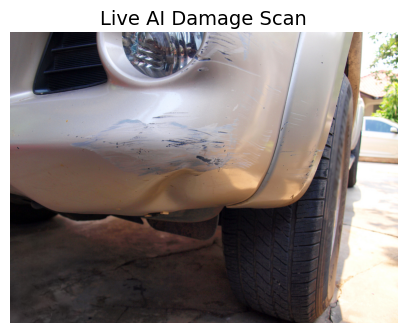


VECTOR ANALYSIS
  Magnitude : 18.1240
  Variance  : 0.164999
  Index     : 19.1244

AI DIAGNOSIS
  Predicted type  : scratch
  Severity score  : 1.50 / 5.0

COST ESTIMATION
  Damage type   : scratch
  Severity      : 1.50 / 5.0
  Predicted cost: $2,206.57


In [18]:
# CHUNK 4 (FINAL HYBRID + CLASSIFIER): Live Demo

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from pyspark.ml import PipelineModel
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing import image

import joblib   # for loading KNN

#  Paths
DATA_DIR   = "/content/cardd"
HDFS_PATH  = "hdfs://localhost:9000/models/car_insurance_gbt_model_final"
LOCAL_PATH = "file:///content/cardd/models/car_insurance_gbt_model"
KNN_PATH   = "/content/cardd/models/damage_type_knn.pkl"

assert os.path.exists(DATA_DIR), "DATA_DIR not found – run earlier chunks first."
assert os.path.exists(KNN_PATH), "KNN classifier file missing – run Chunk 3b."

#  Step 1: Load models
print("Attempting to load GBT model...")

try:
    print(f"  Trying HDFS: {HDFS_PATH}")
    gbt_live_model = PipelineModel.load(HDFS_PATH)
    print("  Loaded from HDFS.")
except Exception as e:
    print(f"  HDFS failed ({str(e)[:60]}...). Falling back to local.")
    gbt_live_model = PipelineModel.load(LOCAL_PATH)
    print("  Loaded from local storage.")

print("Loading EfficientNet backbone...")
cnn_live = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

print("Loading KNN damage-type classifier...")
knn_clf = joblib.load(KNN_PATH)
print("All models ready.")

#  Step 2: Pick image
image_paths = []
for root, dirs, files in os.walk(DATA_DIR):
    for fname in files:
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            image_paths.append(os.path.join(root, fname))

if not image_paths:
    raise RuntimeError("No images found under /content/cardd.")

demo_img_path = random.choice(image_paths)
print(f"\nScanning image: {os.path.basename(demo_img_path)}")

#  Step 3: Show image
img_display = mpimg.imread(demo_img_path)
plt.figure(figsize=(5, 5))
plt.imshow(img_display)
plt.axis("off")
plt.title("Live AI Damage Scan", fontsize=14)
plt.show()

# Step 4: Extract features
def extract_live_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = cnn_live.predict(x, verbose=0)[0]
    return feat.astype("float32")

features = extract_live_features(demo_img_path)

# Step 5: Vector-based severity
vector_magnitude = float(np.linalg.norm(features))
vector_variance  = float(np.var(features))

damage_index  = 0.6 * vector_magnitude + 50.0 * vector_variance
severity_raw  = np.log1p(damage_index) / 2.0
severity_score = float(np.clip(severity_raw, 0.5, 5.0))

# Step 6: Use KNN to classify damage type
damage_type_pred = knn_clf.predict(features.reshape(1, -1))[0]

print("\nVECTOR ANALYSIS")
print(f"  Magnitude : {vector_magnitude:.4f}")
print(f"  Variance  : {vector_variance:.6f}")
print(f"  Index     : {damage_index:.4f}")

print("\nAI DIAGNOSIS")
print(f"  Predicted type  : {damage_type_pred}")
print(f"  Severity score  : {severity_score:.2f} / 5.0")

# Step 7: Build Spark row for pricing
rng = np.random.default_rng()
driver_age = int(rng.integers(20, 70))
car_year   = int(rng.integers(2008, 2024))
car_age    = 2025 - car_year
mileage    = int(np.clip(car_age * 12000 + rng.normal(0, 8000), 5000, 240000))

schema = StructType([
    StructField("claim_id",       StringType(), True),
    StructField("image_path",     StringType(), True),
    StructField("features",       ArrayType(FloatType()), True),
    StructField("driver_age",     IntegerType(), True),
    StructField("car_year",       IntegerType(), True),
    StructField("mileage",        IntegerType(), True),
    StructField("damage_type",    StringType(), True),
    StructField("severity_score", FloatType(), True),
])

row_data = [(
    "demo_claim_1",
    demo_img_path,
    features.tolist(),
    driver_age,
    car_year,
    mileage,
    damage_type_pred,
    severity_score,
)]

demo_df = spark.createDataFrame(row_data, schema)

to_vector = udf(lambda xs: Vectors.dense(xs), VectorUDT())
demo_df = demo_df.withColumn("features_vec", to_vector("features"))

# Step 8: Price prediction
predicted_df = gbt_live_model.transform(demo_df)
result = predicted_df.select("damage_type", "severity_score", "prediction").collect()[0]
pred_cost = result["prediction"]

print("\nCOST ESTIMATION")
print(f"  Damage type   : {result['damage_type']}")
print(f"  Severity      : {result['severity_score']:.2f} / 5.0")
print(f"  Predicted cost: ${pred_cost:,.2f}")


In [14]:
# === SAVE GBT MODEL LOCALLY ===

SAVE_PATH = "/content/cardd/models/car_insurance_gbt_model_saved"

print("Saving GBT model to:", SAVE_PATH)

# gbt_live_model is the model you just loaded in the previous cell
gbt_live_model.write().overwrite().save(SAVE_PATH)

print("Model saved successfully.")


Saving GBT model to: /content/cardd/models/car_insurance_gbt_model_saved
Model saved successfully.


In [15]:
from google.colab import drive
drive.mount('/content/drive')

DRIVE_MODEL_PATH = "/content/drive/MyDrive/car_insurance_gbt_model_saved"

print("Saving model to Google Drive...")
gbt_live_model.write().overwrite().save(DRIVE_MODEL_PATH)

print("Model successfully saved in Drive at:")
print(DRIVE_MODEL_PATH)


Mounted at /content/drive
Saving model to Google Drive...
Model successfully saved in Drive at:
/content/drive/MyDrive/car_insurance_gbt_model_saved


In [16]:
import joblib

SAVE_PATH = "/content/drive/MyDrive/damage_type_knn.pkl"

joblib.dump(knn_clf, SAVE_PATH)

print("✔ KNN model saved to Google Drive at:", SAVE_PATH)


✔ KNN model saved to Google Drive at: /content/drive/MyDrive/damage_type_knn.pkl


In [17]:

# UI CHUNK: Interactive Web App


!pip install -q gradio

import os
import numpy as np
import gradio as gr
import joblib

from pyspark.ml import PipelineModel
from pyspark.sql.types import (
    StructType, StructField, StringType,
    IntegerType, FloatType, ArrayType
)
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.preprocessing import image

# -------- 1. Load models (adjust paths if yours differ) --------
GBT_PATH = "file:///content/cardd/models/car_insurance_gbt_model"
KNN_PATH = "/content/cardd/models/damage_type_knn.pkl"

print("Loading GBT regression model...")
gbt_live_model = PipelineModel.load(GBT_PATH)

print("Loading KNN damage-type classifier...")
knn_clf = joblib.load(KNN_PATH)

print("Loading EfficientNet backbone...")
cnn_live = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg")

print("Models ready.")


#  2. Helper: PIL image -> EfficientNet feature vector
def pil_to_features(pil_img):
    # Ensure RGB and resize to 224x224
    pil_img = pil_img.convert("RGB").resize((224, 224))
    x = np.array(pil_img).astype("float32")
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = cnn_live.predict(x, verbose=0)[0]
    return feat.astype("float32")


#  3. Main prediction function used by the UI
def predict_claim(
    img,
    driver_age,
    car_year,
    mileage,
    auto_damage_type,
    manual_damage_type
):
    if img is None:
        return "Please upload a car damage image."

    # A. Extract deep features from image
    features = pil_to_features(img)

    # B. Vector-based severity
    vector_magnitude = float(np.linalg.norm(features))
    vector_variance  = float(np.var(features))
    damage_index     = 0.6 * vector_magnitude + 50.0 * vector_variance
    severity_raw     = np.log1p(damage_index) / 2.0
    severity_score   = float(np.clip(severity_raw, 0.5, 5.0))

    # C. Damage type: auto from KNN or manual
    if auto_damage_type:
        damage_type = knn_clf.predict(features.reshape(1, -1))[0]
        source = "KNN classifier (auto)"
    else:
        damage_type = manual_damage_type
        source = "manual selection"

    # D. Build Spark row for GBT model
    schema = StructType([
        StructField("claim_id",       StringType(), True),
        StructField("image_path",     StringType(), True),
        StructField("features",       ArrayType(FloatType()), True),
        StructField("driver_age",     IntegerType(), True),
        StructField("car_year",       IntegerType(), True),
        StructField("mileage",        IntegerType(), True),
        StructField("damage_type",    StringType(), True),
        StructField("severity_score", FloatType(), True),
    ])

    row_data = [(
        "ui_demo_claim",
        "uploaded_image",
        features.tolist(),
        int(driver_age),
        int(car_year),
        int(mileage),
        str(damage_type),
        float(severity_score),
    )]

    sdf = spark.createDataFrame(row_data, schema)

    to_vector = udf(lambda xs: Vectors.dense(xs), VectorUDT())
    sdf = sdf.withColumn("features_vec", to_vector("features"))

    # E. Price prediction
    pred_df = gbt_live_model.transform(sdf)
    result = pred_df.select("damage_type", "severity_score", "prediction").collect()[0]
    pred_cost = float(result["prediction"])

    # F. Nicely formatted text output
    text = []
    text.append("IMAGE ANALYSIS")
    text.append(f"• Vector magnitude: {vector_magnitude:.4f}")
    text.append(f"• Vector variance:  {vector_variance:.6f}")
    text.append(f"• Damage index:     {damage_index:.4f}")
    text.append("")
    text.append("AI DIAGNOSIS")
    text.append(f"• Damage type:      {result['damage_type']}  (source: {source})")
    text.append(f"• Severity score:   {result['severity_score']:.2f} / 5.0")
    text.append("")
    text.append("INPUT VEHICLE INFO")
    text.append(f"• Driver age:       {int(driver_age)}")
    text.append(f"• Car year:         {int(car_year)}")
    text.append(f"• Mileage:          {int(mileage):,} miles")
    text.append("")
    text.append("COST ESTIMATE")
    text.append(f"• Predicted repair cost:  ${pred_cost:,.2f}")

    if pred_cost > 5000:
        text.append("• Assessment: TOTAL LOSS / VERY MAJOR REPAIR")
    elif pred_cost > 2500:
        text.append("• Assessment: MAJOR REPAIR")
    else:
        text.append("• Assessment: STANDARD / MINOR REPAIR")

    return "\n".join(text)


#  4. Build Gradio interface (larger output box)
damage_options = ["scratch", "crack", "dent", "tire_flat", "glass_shatter"]

iface = gr.Interface(
    fn=predict_claim,
    inputs=[
        gr.Image(type="pil", label="Upload damaged car image"),
        gr.Slider(18, 80, value=35, step=1, label="Driver age"),
        gr.Slider(2000, 2024, value=2015, step=1, label="Car year"),
        gr.Number(value=60000, label="Mileage (miles)"),
        gr.Checkbox(value=True, label="Auto-detect damage type from image"),
        gr.Dropdown(damage_options, value="scratch",
                    label="Manual damage type (used if auto off)"),
    ],
    outputs=gr.Textbox(
        label="AI Assessment",
        lines=15,      # taller display
        max_lines=30
    ),
    title="Car Damage Claim Estimator",
    description="Upload a damaged car photo and enter vehicle details. "
                "The system estimates damage type, severity, and repair cost."
)

iface.launch()


Loading GBT regression model...
Loading KNN damage-type classifier...
Loading EfficientNet backbone...
Models ready.
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://074a2a703958f7325a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
